In [10]:
import torch
import numpy as np
seed = 37
torch.manual_seed(seed)
np.random.seed(seed)

import sys
sys.path.append("../../../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    TFTModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt
import tsaug
import ray
from ray import tune
import os
from matplotlib.pyplot import figure

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

figure(figsize=(8, 4), dpi=120)


dl =  DatasetLoader( '../../data/alibaba_hourly_cpu_gpu_mem_usage.csv', "Time",
                                                                    [
                                                                      "cpu_usage",
                                                                      "gpu_wrk_util",
                                                                      "avg_gpu_wrk_mem"
                                                                     ],
                    resample_freq="H", augment=False, 
                    shift_df_datetime="2022-01-02 00:00:00",
                    fill_missing_dates=True)
train, val = dl.get_train_val_by_date("2022-02-14 23:59:00")

<Figure size 960x480 with 0 Axes>

In [11]:
quantiles = [0.1, 0.5, 0.9]

model = TFTModel(
    input_chunk_length=6,
    output_chunk_length=6,
    hidden_size = 64,
    lstm_layers= 4,
    num_attention_heads= 8,
    optimizer_kwargs= {'lr': 0.001},
    n_epochs=50,
    dropout=0.1,
    save_checkpoints=True,
     add_encoders={
    'cyclic': {'past': ['day','dayofweek', 'hour'] , 'future': ['day','dayofweek', 'hour']},
    "datetime_attribute": {"past": ["month"], "future": ["month"] },
    'transformer': Scaler()
    },
    likelihood=QuantileRegression(
        quantiles=quantiles
    ), 
    work_dir="logs/tft_nohparam",
    nr_epochs_val_period=1,
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    torch_device_str='cuda:0'
)

In [12]:
model.fit(train, val_series=val, verbose=True)

[2022-04-07 17:48:04,562] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1044 samples.
[2022-04-07 17:48:04,562] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1044 samples.
[2022-04-07 17:48:04,606] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-07 17:48:04,606] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

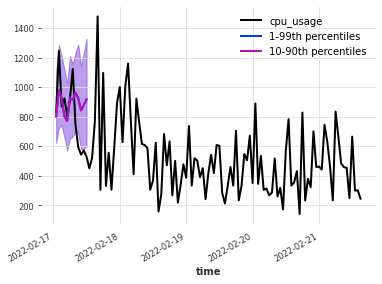

<Figure size 960x480 with 0 Axes>

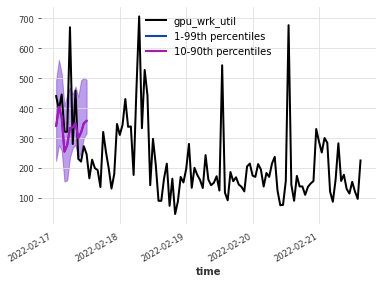

<Figure size 960x480 with 0 Axes>

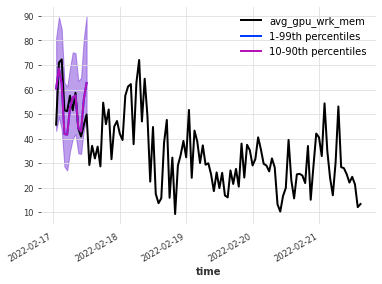

<Figure size 960x480 with 0 Axes>

In [16]:
cut_off = 50
pred_len = 12
pred = model.predict(series=val[:cut_off], n=pred_len, num_samples=100)
pred = dl.scaler.inverse_transform(pred)
val_back = dl.scaler.inverse_transform(val)
for i in range(pred.n_components):
    val_back[cut_off:cut_off+pred_len+24*7].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.05, high_quantile=0.95, label="1-99th percentiles")
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9,  label="10-90th percentiles")
    figure(figsize=(8, 4), dpi=120)
    plt.savefig(str(i))
    plt.show()